# Local Spatial Autocorrelation

- Despite their importance, global measures of spatial autocorrelation are “whole map” statistics. They provide a single summary for an entire data set. For example, Moran’s I is a good tool to summarize a dataset into a single value that captures the degree of geographical clustering (or dispersion, if negative). However, Moran’s I does not indicate areas within the map where specific types of values (e.g. high, low) are clustered, or instances of explicit dispersion. In other words, Moran’s I can tell us whether values in our map cluster together (or disperse) overall, but it will not inform us about where specific clusters (or outliers) are.

* In this chapter, we introduce local measures of spatial autocorrelation. Local measures of spatial autocorrelation focus on the relationships between each observation and its surroundings, rather than providing a single summary of these relationships across the map. 

## An empirical illustration: the EU Referendum

In [6]:
import matplotlib.pyplot as plt 
from matplotlib import colors
import seaborn as sns  # Graphics
import geopandas as gpd  # Spatial data manipulation
import pandas as pd  
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles


In [5]:
ref = pd.read_csv(
    "./geo_data/brexit/brexit_vote.csv", index_col="Area_Code"
)

In [7]:
lads = gpd.read_file(
    "./geo_data/brexit/local_authority_districts.geojson"
).set_index("lad16cd")

In [8]:
# Trim the dataframe

db = (
    geopandas.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Leave", "geometry"]
    ]
    .dropna()
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 22.9+ KB


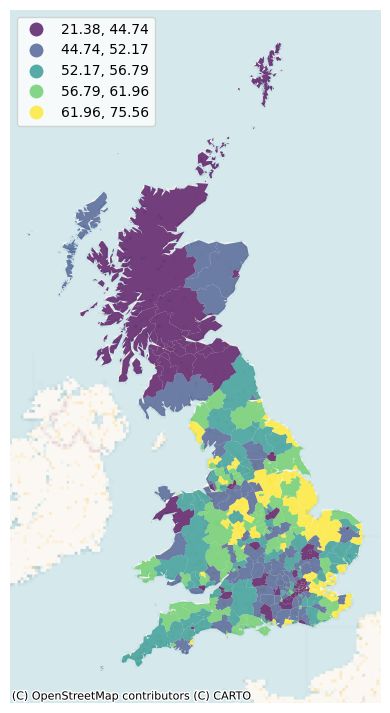

In [9]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

In [10]:
# Spatial weights matrix

# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

### Motivating Local Spatial Autocorrelation

In [11]:
# Calculate the spatial lag structure

In [12]:
db["w_Pct_Leave"] = weights.spatial_lag.lag_spatial(
    w, db["Pct_Leave"]
)

In [14]:
# Standardize

db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["w_Pct_Leave_std"] = db["w_Pct_Leave"] - db["Pct_Leave"].mean()



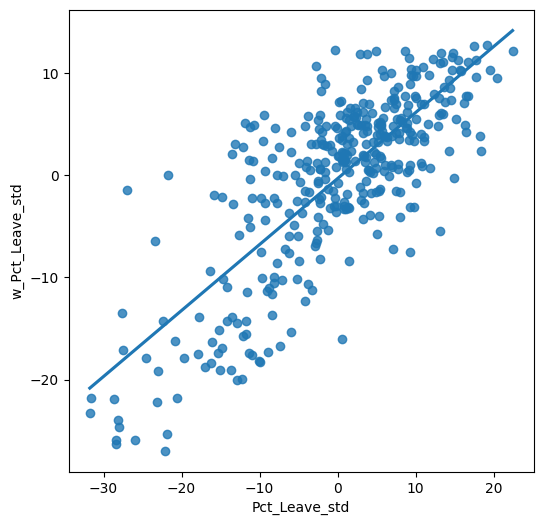

In [16]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
);

- Using standardized values, we can immediately divide each variable (the percentage that voted to leave, and its spatial lag) in two groups: those with above-average leave voting, which have positive standardized values; and those with below-average leave voting, which feature negative standardized values.

*  Applying this thinking to both the percentage to leave and its spatial lag, divides a Moran Plot in four quadrants. Each of them captures a situation based on whether a given area displays a value above the mean (high) or below (low) in either the original variable (Pct_Leave) or its spatial lag (w_Pct_Leave_std). Using this terminology, we name the four quadrants as follows: high-high (HH) for the top-right, low-high (LH) for the top-left, low-low (LL) for the bottom-left, and high-low (HL) for the bottom right. Graphically, we can capture this as follows:

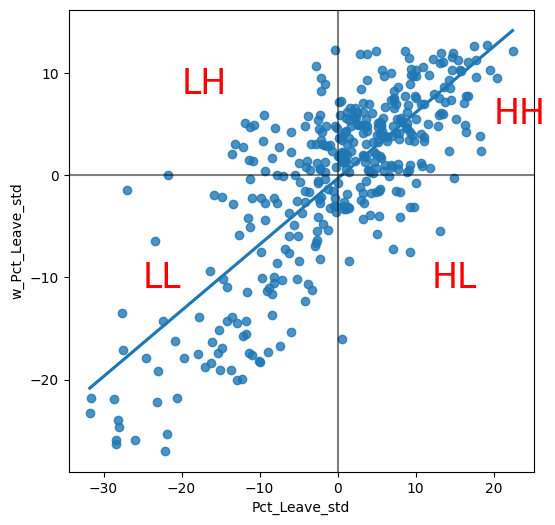

In [18]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()


## Local Moran’s Ii


- One way to look at the figure above is as a classification of each observation in the dataset depending on its value and that of its neighbors